# 1. Project Initialization and Dataset Acquisition
This section sets up the local development environment for the **Continuous Bangladeshi Sign Language (BDSL)** research project. 
### **Workflow:**
* **Directory Management:** Setting the workspace to the dedicated project folder on the local machine.
* **Git LFS (Large File Storage):** Initializing LFS to handle the large-scale video files contained in the dataset.
* **Dataset Cloning:** Pulling the `Ban-Sign-Sent-9K-V1` dataset from Hugging Face .
* **Conditional Logic:** The script checks if the dataset already exists locally to avoid redundant downloads and save storage space.

In [ ]:
# 1. Change directory using the magic command
#%cd "C:\Users\Munna\Documents\BdSL_Project"

# 2. Install Git LFS (using !)
#!git lfs install

# 3. Clone the dataset (using !)
#!git clone https://huggingface.co/datasets/banglagov/Ban-Sign-Sent-9K-V1

import os

# 1. Go to project folder
%cd "C:\Users\Munna\Documents\BdSL_Project"

# 2. Checking if dataset already exists
if os.path.exists("Ban-Sign-Sent-9K-V1"):
    print("✅ Dataset already exists! Skipping download.")
else:
    print("⏳ Downloading dataset...")
    !git lfs install
    !git clone https://huggingface.co/datasets/banglagov/Ban-Sign-Sent-9K-V1

C:\Users\Munna\Documents\BdSL_Project
✅ Dataset already exists! Skipping download.


c:\Users\Munna\Documents\BdSL_Project\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


### 2. Dataset Structure Inspection
In this step, we verify the integrity of the downloaded dataset. We are specifically looking for the `Sign_Videos` directories, which contain the raw video data organized by folders. 

**Purpose:**
* Confirm the path is correct.
* Check if the dataset parts (Sign_Videos) are present.
* Ensure the directory structure matches the expected format for processing.


In [54]:
import os

dataset_path = r"C:\Users\Munna\Documents\BdSL_Project\Ban-Sign-Sent-9K-V1"
parts = [f for f in os.listdir(dataset_path) if f.startswith("Sign_Videos")]
print("Found parts:", parts)
print("Total parts:", len(parts))

Found parts: ['Sign_Videos', 'Sign_Videos.z01', 'Sign_Videos.z02', 'Sign_Videos.z03', 'Sign_Videos.z04', 'Sign_Videos.z05', 'Sign_Videos.z06', 'Sign_Videos.z07', 'Sign_Videos.z08', 'Sign_Videos.z09', 'Sign_Videos.zip']
Total parts: 11


### 3. Video Directory Verification
After locating the dataset parts, we pinpoint the specific directory containing the training samples. This step validates that the video data is accessible and correctly organized for the **Continuous Bangladeshi Sign Language (BDSL)** recognition task.

**Objectives:**
* **Path Validation:** Confirm that the absolute path to the `Sign_Videos` folder is valid on the local system.
* **Inventory Count:** Determine the total number of unique folders present, where each folder represents a specific sentence ID.
* **Structure Sampling:** Preview the first 10 folder names to ensure they align with the **Sentence IDs** found in the metadata. 

In [3]:
import os

videos_path = r"C:\Users\Munna\Documents\BdSL_Project\Ban-Sign-Sent-9K-V1\Sign_Videos"
print("✅ Videos folder exists:", os.path.exists(videos_path))
print("📦 Total videos:", len(os.listdir(videos_path)))
print("🔍 First 10 folders:", os.listdir(videos_path)[:10])

✅ Videos folder exists: True
📦 Total videos: 1922
🔍 First 10 folders: ['12419', '18577', '19414', '23511', '25406', '25407', '25408', '25411', '25770', '25771']


### 4. Metadata Acquisition and Dataframe Initialization
In this phase, we bridge the gap between the raw video files and their corresponding linguistic labels. We utilize the `pandas` library to load the dataset's primary metadata file.

**Key Operations:**
* **Excel Parsing:** Reading the `Bangla_Sign_Sentence.xlsx` file which contains the ground truth for each sign sequence.
* **Data Inspection:** Displaying the first few rows (head) of the dataframe to understand the relationship between `Sentence ID`, `Sign Sentence` (Glosses), and `Natural Sentence` (Bangla).
* **Integrity Check:** Confirming the total count of metadata rows to ensure it matches the expected dataset size for our research.

In [4]:
import pandas as pd

xls_path = r"C:\Users\Munna\Documents\BdSL_Project\Ban-Sign-Sent-9K-V1\Bangla_Sign_Sentence.xlsx"
df = pd.read_excel(xls_path)

print("🧾 Total metadata rows:", len(df))
print(df.head())

🧾 Total metadata rows: 1922
   Sentence ID         Natural Sentence       Sign Sentence
0        23511                  ফল খাও।          ফল খাওয়া।
1        27934    বাবা সকালে চা খান না।    বাবা সকাল চা না।
2        27941    বাবা বিকালে চা খায়নি।  বাবা বিকাল চা নেই।
3        27946  বাবা বিকালে চা খাবে না।   বাবা বিকাল চা না।
4        27959      বাবা সকালে চা খাবে।   বাবা সকাল চা হবে।


### 5. Label-to-Video Mapping Construction
This step is critical for building a high-performance **Continuous Bangladeshi Sign Language (BDSL)** recognition system. We transform the flat metadata into a fast-lookup dictionary that links each unique **Sentence ID** to its linguistic labels.

**Research Objectives:**
* **Dictionary Transformation:** Converting the Pandas DataFrame into a Python dictionary for $O(1)$ search efficiency during the data loading process.
* **Feature Pairing:** Storing both the **Sign Sentence (Glosses)** and the **Natural Bangla translation** for each video ID.
* **Integrity Validation:** Testing the mapping with a known ID (e.g., '29845') to ensure the data is correctly structured before training the **ResNet50 + BiLSTM** model.

In [5]:
import os

videos_path = r"C:\Users\Munna\Documents\BdSL_Project\Ban-Sign-Sent-9K-V1\Sign_Videos"

mapping = {}
for _, row in df.iterrows():
    vid_id = str(row['Sentence ID'])
    mapping[vid_id] = {
        "gloss": row['Sign Sentence'],
        "bangla": row['Natural Sentence']
    }

print("Sample mapping:", mapping['29845'])  # test with a known ID

Sample mapping: {'gloss': 'খালা জামাই দুপুর ফল খাওয়ায়া হয়েছে।', 'bangla': 'খালু দুপুরে ফল খেয়েছে।'}


### 6. Video Sample Aggregation and Path Binding
In this phase, we finalize the dataset preparation by scanning the local file system and pairing every individual `.mp4` file with its corresponding metadata. This creates the master list of samples that will be used for training, validation, and testing.

**Workflow Components:**
* **Directory Traversal:** Iterating through each folder in the `Sign_Videos` directory to locate the raw video files.
* **Metadata Fusion:** Using the previously created mapping to attach the correct **Sign Sentence (Gloss)** and **Natural Bangla Sentence** to each video's file path.
* **File Validation:** Filtering for `.mp4` extensions and ensuring only directories with valid metadata are included in the final sample list.
* **Inventory Verification:** Confirming the total number of samples collected and inspecting a sample object to verify that the file paths and labels are correctly bound.

In [6]:
all_samples = []
for vid_id in os.listdir(videos_path):
    folder_path = os.path.join(videos_path, vid_id)
    if os.path.isdir(folder_path) and vid_id in mapping:
        for file in os.listdir(folder_path):
            if file.endswith(".mp4"):
                all_samples.append({
                    "path": os.path.join(folder_path, file),
                    "gloss": mapping[vid_id]["gloss"],
                    "bangla": mapping[vid_id]["bangla"]
                })

print("Total samples:", len(all_samples))
print("Example sample:", all_samples[0])

Total samples: 9610
Example sample: {'path': 'C:\\Users\\Munna\\Documents\\BdSL_Project\\Ban-Sign-Sent-9K-V1\\Sign_Videos\\12419\\UL_CS_S12419_U19_20230706_1688653207413.mp4', 'gloss': 'রাত খাওয়ায়া হয়েছে ?', 'bangla': 'রাতে খেয়েছেন?'}


### 7. Dataset Partitioning (Train, Validation, and Test Splits)
To ensure the model generalizes well and avoids overfitting, we partition the total collection of samples into three distinct subsets. This is a standard procedure in developing a robust **Continuous Bangladeshi Sign Language (BDSL)** recognition system.



**Partitioning Strategy:**
* **Random Shuffling**: We use `random.shuffle` to ensure that the distribution of signs and sentence types is uniform across all splits, preventing the model from learning biased patterns based on file order.
* **Training Set (80%)**: The largest portion of the data is allocated for the model to learn the spatial features (via **ResNet50**) and temporal sequences (via **BiLSTM**).
* **Validation Set (10%)**: This set is used during the training process to monitor performance and tune hyperparameters, such as the learning rate and CTC loss weights.
* **Testing Set (10%)**: A completely unseen portion of the data used for final evaluation to report the **Sentence Accuracy** and **Word Accuracy** in our research paper.

In [7]:
import random
random.shuffle(all_samples)

train_split = int(0.8 * len(all_samples))
val_split   = int(0.9 * len(all_samples))

train_samples = all_samples[:train_split]
val_samples   = all_samples[train_split:val_split]
test_samples  = all_samples[val_split:]

print("Train:", len(train_samples), "Val:", len(val_samples), "Test:", len(test_samples))

Train: 7688 Val: 961 Test: 961


### 8. Custom PyTorch Dataset for Video Sequence Processing
This section defines the core data pipeline for our **Continuous Bangladeshi Sign Language (BDSL)** recognition system. The `BdSLDataset` class transforms raw video files into structured tensors compatible with the **ResNet50 + BiLSTM** architecture.

**Key Technical Implementations:**
* **Temporal Downsampling (`frame_skip`)**: To optimize the 6GB memory of the **RTX 4050 GPU**, we sample every 3rd frame. This retains the essential motion patterns while significantly reducing computational overhead.
* **Spatial Normalization**: Each frame is resized to $224 \times 224$ pixels and normalized to a range of $[0, 1]$ to match the input requirements of the pre-trained **ResNet50** feature extractor.
* **Fixed-Length Sequence Management**: 
    * **Truncation**: Videos longer than 20 sampled frames are cut to maintain uniform batch shapes.
    * **Zero-Padding**: Shorter sequences are padded with zero-tensors, ensuring that the **BiLSTM** receives consistent input dimensions across all training batches.
* **Channel Permutation**: Adjusts the image dimensions from $(H, W, C)$ to the PyTorch standard $(C, H, W)$ for seamless tensor processing.

In [8]:
import torch
from torch.utils.data import Dataset
import cv2

class BdSLDataset(Dataset):
    def __init__(self, samples, max_frames=20, frame_skip=3):
        """
        samples: list of dicts with {path, gloss, bangla}
        max_frames: maximum frames per video (truncate/pad)
        frame_skip: take every Nth frame to reduce memory
        """
        self.samples = samples
        self.max_frames = max_frames
        self.frame_skip = frame_skip

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        video_path = sample["path"]
        gloss = sample["gloss"]
        bangla = sample["bangla"]

        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            if frame_count % self.frame_skip == 0:  # sample frames
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = cv2.resize(frame, (224, 224))
                frame = torch.tensor(frame, dtype=torch.float32).permute(2,0,1) / 255.0
                frames.append(frame)
            frame_count += 1
        cap.release()

        # Pad or truncate
        if len(frames) > self.max_frames:
            frames = frames[:self.max_frames]
        else:
            pad_len = self.max_frames - len(frames)
            if frames:  # pad only if frames exist
                frames += [torch.zeros_like(frames[0])] * pad_len
            else:
                frames = [torch.zeros(3,224,224)] * self.max_frames

        frames = torch.stack(frames)
        return frames, gloss, bangla

### 9. DataLoader Initialization and Batch Verification
This stage prepares the data for the iterative training process using the `DataLoader` utility. It manages how samples are batched and fed into the **ResNet50 + BiLSTM** model  .

**Operational Details:**
* **Batch Configuration**: We utilize a `batch_size=2` to ensure the high-dimensional video tensors (frames) fit within the GPU's VRAM during the forward and backward passes.
* **Stochastic Training**: The `shuffle=True` parameter is applied to the `train_loader` to ensure the model does not learn the order of the Bangladeshi Sign Language (BDSL) dataset, promoting better generalization.
* **Multi-stage Pipeline**: Separate loaders are created for training, validation, and testing to maintain strict isolation between the learning phase and final performance reporting.
* **Shape Validation**: By inspecting the first batch, we verify the tensor dimensions—specifically $(Batch, Frames, Channels, Height, Width)$—ensuring the data pipeline correctly feeds the model.

In [9]:
from torch.utils.data import DataLoader

train_loader = DataLoader(BdSLDataset(train_samples, max_frames=20, frame_skip=3), batch_size=2, shuffle=True)
val_loader   = DataLoader(BdSLDataset(val_samples, max_frames=20, frame_skip=3), batch_size=2)
test_loader  = DataLoader(BdSLDataset(test_samples, max_frames=20, frame_skip=3), batch_size=2)

frames, gloss, bangla = next(iter(train_loader))
print("Batch frames shape:", frames.shape)
print("Gloss example:", gloss[0])
print("Bangla example:", bangla[0])

Batch frames shape: torch.Size([2, 20, 3, 224, 224])
Gloss example: বাবা সন্ধ্যা ফল খাওয়ায়া ছিল।
Bangla example: বাবা সন্ধ্যায় ফল খেয়েছিল।


### 10. Hybrid Deep Learning Architecture (ResNet50 + BiLSTM)
This section defines the core neural network designed for **Continuous Bangladeshi Sign Language (BDSL)** recognition. The model follows a **Convolutional Recurrent Neural Network (CRNN)** approach to process both the spatial details of hand gestures and the temporal flow of sign sequences.

**Architectural Components:**
* **Spatial Feature Extractor (ResNet50):** We utilize a pre-trained **ResNet50** model as the backbone to extract high-level visual features from individual video frames. The final fully connected layer is replaced with an `Identity` layer to preserve the 2048-dimensional feature vector.
* **Temporal Sequence Processor (BiLSTM):** To understand the movement and context of sign language, we employ a **2-layer Bidirectional LSTM**. This allows the model to process information from both past and future frames in the sequence, which is essential for continuous sign recognition.
* **Feature Integration:** The model reshapes the input batches to process frames through the ResNet backbone before re-assembling them for the sequence-learning LSTM layer.
* **Classification Head:** A final linear layer maps the 512-dimensional hidden state (doubled due to bidirectionality) to the total number of classes in our vocabulary.

In [10]:
import torch.nn as nn
from torchvision.models import resnet50, ResNet50_Weights

class SignModel(nn.Module):
    def __init__(self, hidden_size=256, num_classes=5000):
        super(SignModel, self).__init__()
        resnet = resnet50(weights=ResNet50_Weights.DEFAULT)  # ✅ modern way
        resnet.fc = nn.Identity()
        self.feature_extractor = resnet

        self.lstm = nn.LSTM(
            input_size=2048, hidden_size=hidden_size,
            num_layers=2, batch_first=True, bidirectional=True
        )
        self.fc = nn.Linear(hidden_size*2, num_classes)

    def forward(self, x):
        batch, frames, c, h, w = x.shape
        x = x.view(batch*frames, c, h, w)
        features = self.feature_extractor(x)
        features = features.view(batch, frames, -1)
        lstm_out, _ = self.lstm(features)
        logits = self.fc(lstm_out)
        return logits

### 11. Loss Function and Optimizer Selection
This stage configures the mathematical objective and the learning strategy for the **Continuous Bangladeshi Sign Language (BDSL)** recognition model. These parameters are crucial for steering the **ResNet50 + BiLSTM** architecture toward accurate convergence.

**Key Components:**
* **Connectionist Temporal Classification (CTC) Loss**: We utilize `nn.CTCLoss` because it is specifically designed for sequence tasks where the alignment between the input (video frames) and the target (sentence tokens) is unknown. 
    * The `blank=0` parameter designates the first index of our vocabulary as the "blank" token, a requirement for CTC to distinguish between repeating characters and transitions.
* **Model Hyperparameters**: The model is initialized with a `hidden_size=256` for the LSTM layers and a capacity for 5,000 unique classes, providing enough complexity to learn the nuances of the Bangladeshi Sign Language dataset.
* **Adam Optimizer**: We employ the **Adam** (Adaptive Moment Estimation) optimizer with a learning rate of `1e-4`. 

In [11]:
criterion = nn.CTCLoss(blank=0)
model = SignModel(hidden_size=256, num_classes=5000)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

### 12. Vocabulary Generation and Sequence Encoding
This section establishes the linguistic framework for the **Continuous Bangladeshi Sign Language (BDSL)** recognition system. Since our research involves translating video sequences into text, we must convert raw sign sentences into a numerical format that the **ResNet50 + BiLSTM** model can process.

**Implementation Details:**
* **Corpus Analysis**: We extract all **Glosses (Sign Sentences)** from the training partition to identify the unique vocabulary used in the **Ban-Sign-Sent-9K-V1** dataset.
* **Vocabulary Mapping**: Each unique token is assigned a unique integer ID. We use a **1-based index** (`idx + 1`) to reserve **ID 0** for the CTC "blank" token, which is essential for the temporal classification logic.
* **Batch Encoding Function (`encode_gloss_batch`)**:
    * **Tokenization**: Converts a batch of human-readable sign sentences into lists of integer IDs based on our generated vocabulary.
    * **Target Flattening**: Joins all encoded sequences into a single 1D tensor, a format specifically required by PyTorch's `nn.CTCLoss`.
    * **Length Tracking**: Maintains a record of each sentence's original word count, allowing the loss function to differentiate between individual samples in a processed batch.

In [55]:
glosses = [s["gloss"] for s in train_samples]
unique_tokens = sorted(set(" ".join(glosses).split()))
vocab = {token: idx+1 for idx, token in enumerate(unique_tokens)}  # +1 to reserve 0 for blank

def encode_gloss_batch(gloss_batch, vocab):
    targets = []
    lengths = []
    for gloss in gloss_batch:
        tokens = [vocab[token] for token in gloss.split()]
        targets.extend(tokens)
        lengths.append(len(tokens))
    return torch.tensor(targets, dtype=torch.long), torch.tensor(lengths, dtype=torch.long)

### 13. Hardware Acceleration and Initial Forward Pass Validation
This section transitions our research into the active training phase by leveraging the available hardware acceleration. We perform a "sanity check" to ensure that the **ResNet50 + BiLSTM** architecture correctly processes data through the **CTC Loss** pipeline without errors.

**Workflow Components:**
* **GPU Migration:** The model and tensors are moved to the available `cuda` device, specifically utilizing the **RTX 4050 6GB GPU** to handle the intensive computational requirements of video-based deep learning.
* **Gradient-Free Inference:** We use `torch.no_grad()` to perform a test forward pass. This verifies that the input tensor dimensions match the model's expectations without consuming unnecessary memory or updating weights.
* **Logit and Probability Calculation:** * The model produces raw **Logits** representing the prediction for each frame.
    * These are converted into **Log Probabilities** using `log_softmax`, which is a standard requirement for the CTC algorithm.
* **Target Encoding and Length Matching:** We prepare the ground truth labels and input frame lengths (`input_lengths`) to satisfy the structural requirements of the loss function.
* **Loss Verification:** A single **CTC Loss** value is computed. A successful numerical output here confirms that our data pipeline, model architecture, and loss configuration are perfectly synchronized for the **Continuous Bangladeshi Sign Language (BDSL)** dataset.

In [13]:
# Move model and data to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Get one batch safely
frames, gloss, bangla = next(iter(train_loader))
frames = frames.to(device)   # ✅ move batch to GPU/CPU device

with torch.no_grad():        # ✅ disable gradients for test run
    logits = model(frames)   # (batch, frames, num_classes)
print("Logits shape:", logits.shape)

# Compute log probabilities
log_probs = nn.functional.log_softmax(logits, dim=2)

# Encode gloss targets
targets, target_lengths = encode_gloss_batch(gloss, vocab)

# Input lengths for CTC (all frames padded to same length)
input_lengths = torch.full(
    size=(logits.size(0),),
    fill_value=logits.size(1),
    dtype=torch.long
)

# Compute CTC loss
loss = criterion(log_probs.permute(1,0,2), targets, input_lengths, target_lengths)
print("✅ CTC Loss:", loss.item())

Logits shape: torch.Size([2, 20, 5000])
✅ CTC Loss: 35.09398651123047


### 14. CTC Greedy Decoding and Performance Metrics
As part of the **Continuous Bangladeshi Sign Language (BDSL)** research journey, this section implements the logic required to translate the model's raw output back into human-readable sentences and measure the system's success.

**Technical Implementation:**
* **Greedy CTC Decoding (`ctc_decode`)**:
    * **Best-Path Selection**: We use `torch.argmax` to select the most likely token for each individual frame.
    * **Sequence Compression**: The function implements the core CTC logic by collapsing repeated tokens and removing the **"blank" (ID 0)** tokens. This is essential for transforming a 20-frame prediction into a concise word sequence.
* **Sentence-Level Accuracy (`calculate_accuracy`)**:
    * **Exact Match Metric**: This function calculates the percentage of total samples where the predicted sequence of sign glosses perfectly matches the ground truth.
    * **Binary Success**: It treats a sentence as correct only if every word in the **Bangla sign sequence** is identified in the correct order, providing a high bar for model performance evaluation.

In [14]:
def ctc_decode(logits, blank=0):
    preds = torch.argmax(logits, dim=2)
    preds = preds.cpu().numpy().tolist()
    decoded = []
    for seq in preds:
        prev = None
        out = []
        for p in seq:
            if p != blank and p != prev:
                out.append(p)
            prev = p
        decoded.append(out)
    return decoded

def calculate_accuracy(preds, targets):
    correct = 0
    total = len(targets)
    for p, t in zip(preds, targets):
        if p == t:
            correct += 1
    return correct / total if total > 0 else 0

### 15. Training Loop with Mixed Precision and Early Stopping
This section executes the core training phase for the **Continuous Bangladeshi Sign Language (BDSL)** recognition system. 

**Key Implementation Features:**
* **Automatic Mixed Precision (AMP)**: We utilize `torch.cuda.amp` (GradScaler and autocast) to perform certain operations in 16-bit precision. This significantly reduces VRAM usage and speeds up training without sacrificing the accuracy of the **ResNet50 + BiLSTM** model.
* **Early Stopping Mechanism**: To prevent overfitting, the loop monitors the `avg_loss`. If the loss does not improve for a consecutive number of epochs (defined by `patience`), training is terminated to preserve the best version of the model.
* **Checkpointing Strategy**: At the end of every epoch, the model's weights, optimizer state, and current training metrics are saved to the `BdSL_Checkpoints` directory. This allows for recovery in case of hardware failure and facilitates long-term experimentation.
* **Real-time Performance Monitoring**: The loop calculates and prints the average **CTC Loss** and **Training Accuracy** for every epoch, providing a continuous feedback loop on the model's learning progress.

In [32]:
import os
import matplotlib.pyplot as plt

# Checkpoint directory
checkpoint_dir = r"C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

num_epochs = 20
train_losses, train_acc_list = [], []

scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

# Early stopping setup
patience = 3   # কত epoch ধরে improvement না হলে থামবে
best_loss = float('inf')
no_improve = 0

for epoch in range(num_epochs):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    for frames, gloss, bangla in train_loader:
        frames = frames.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(frames)                          # [B, T, C]
            log_probs = nn.functional.log_softmax(logits, dim=2)

            targets, target_lengths = encode_gloss_batch(gloss, vocab)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)
            input_lengths = torch.full(
                (logits.size(0),), logits.size(1), dtype=torch.long, device=device
            )

            loss = criterion(log_probs.permute(1,0,2), targets, input_lengths, target_lengths)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        # Accuracy (greedy decode)
        with torch.no_grad():
            decoded_preds = ctc_decode(logits, blank=0)
            target_ids, _ = encode_gloss_batch(gloss, vocab)
            target_ids = target_ids.cpu().numpy().tolist()
            lengths = [len(g.split()) for g in gloss]
            per_sample_targets = []
            idx = 0
            for L in lengths:
                per_sample_targets.append(target_ids[idx:idx+L])
                idx += L
            batch_acc = calculate_accuracy(decoded_preds, per_sample_targets)
            total_acc += batch_acc

    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    train_losses.append(avg_loss)
    train_acc_list.append(avg_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

    # Save checkpoint
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_loss,
        'train_acc': avg_acc,
        'vocab': vocab
    }, os.path.join(checkpoint_dir, f"checkpoint_epoch{epoch+1}.pt"))

    # -------------------------
    # Early stopping condition
    # -------------------------
    if avg_loss < best_loss:
        best_loss = avg_loss
        no_improve = 0
    else:
        no_improve += 1

    if no_improve >= patience:
        print("⏹ Early stopping triggered!")
        break

C:\Users\Munna\AppData\Local\Temp\ipykernel_18748\2437893678.py:11: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))
C:\Users\Munna\AppData\Local\Temp\ipykernel_18748\2437893678.py:26: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):


Epoch 1/20 | Loss: 2.5084 | Train Acc: 0.0003
Epoch 2/20 | Loss: 1.6513 | Train Acc: 0.0025
Epoch 3/20 | Loss: 1.2004 | Train Acc: 0.0133
Epoch 4/20 | Loss: 1.0035 | Train Acc: 0.0332
Epoch 5/20 | Loss: 0.9022 | Train Acc: 0.0464
Epoch 6/20 | Loss: 0.8085 | Train Acc: 0.0671
Epoch 7/20 | Loss: 0.7388 | Train Acc: 0.0907
Epoch 8/20 | Loss: 0.6792 | Train Acc: 0.1097
Epoch 9/20 | Loss: 0.6507 | Train Acc: 0.1111
Epoch 10/20 | Loss: 0.6286 | Train Acc: 0.1250
Epoch 11/20 | Loss: 0.5926 | Train Acc: 0.1430
Epoch 12/20 | Loss: 0.5700 | Train Acc: 0.1609
Epoch 13/20 | Loss: 0.5342 | Train Acc: 0.1859
Epoch 14/20 | Loss: 0.4991 | Train Acc: 0.2180
Epoch 15/20 | Loss: 0.4567 | Train Acc: 0.2659
Epoch 16/20 | Loss: 0.4061 | Train Acc: 0.3331
Epoch 17/20 | Loss: 0.3530 | Train Acc: 0.4116
Epoch 18/20 | Loss: 0.3059 | Train Acc: 0.4789
Epoch 19/20 | Loss: 0.2589 | Train Acc: 0.5438
Epoch 20/20 | Loss: 0.2205 | Train Acc: 0.6065


### 16. Model State Restoration and Checkpoint Loading
As we progress into the next phase , this step ensures continuity by reloading the previously trained model weights. This is to prevent data loss and to build upon prior computational efforts.

**Implementation Objectives:**
* **Checkpoint Recovery**: We target the saved state from **Epoch 20** to serve as the baseline for our extended training session.
* **State Restoration**:
    * **Model Weights**: Reloading the parameters of the **ResNet50 feature extractor** and **BiLSTM layers**.
    * **Optimizer State**: Restoring the **Adam optimizer** settings to maintain the adaptive learning momentum.
* **Progress Verification**: The script prints the last recorded **CTC Loss** and **Training Accuracy** to confirm that the training resumes from the correct performance plateau.
* **Error Handling**: Includes logic to verify the existence of the `.pt` file, ensuring the research pipeline remains robust on the local file system.

In [ ]:
import torch
import os

checkpoint_dir = r"C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints"

# Find epoch 20 checkpoint
ckpt_path = os.path.join(checkpoint_dir, "checkpoint_epoch20.pt")

if os.path.exists(ckpt_path):
    print(f"🔍 Loading checkpoint: {ckpt_path}")
    checkpoint = torch.load(ckpt_path, map_location=device)
    
    # Restore model and optimizer states
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    start_epoch = checkpoint['epoch']  # This will be 20
    print(f"✅ EPOCH {start_epoch} RESTORED!")
    print(f"📊 Previous Loss: {checkpoint['train_loss']:.4f} | Acc: {checkpoint['train_acc']:.2%}")
else:
    print("❌ Checkpoint not found! Please check your file path.")
    start_epoch = 0

### 16. Research Phase II: Training Continuation (Epochs 21–30)
In this stage , we extend the training of the **ResNet50 + BiLSTM** architecture to further refine the recognition of **Continuous Bangladeshi Sign Language (BDSL)** sequences. This phase is critical for achieving model convergence and reducing the **CTC Loss** to its optimal minimum.



**Methodological Objectives:**
* **Checkpoint Restoration**: We programmatically reload the saved weights and optimizer states from **Epoch 20** to maintain continuity in the learning process.
* **Optimizer Momentum**: By restoring the **Adam optimizer's** state, we ensure that the adaptive learning rates for each parameter are preserved as we move toward **Epoch 30**.
* **Mixed Precision Efficiency**: We continue utilizing **Automatic Mixed Precision (AMP)** to optimize the 6GB VRAM of the **RTX 4050 GPU**, allowing for faster iterations and stable training.
* **Performance Benchmarking**:
    * **Loss Monitoring**: Tracking the average **CTC Loss** to ensure the model is still learning and not overfitting.
    * **Accuracy Recording**: Documenting the **Sentence Accuracy** for each epoch to provide a clear progress graph for the final research paper.
* **Granular Checkpointing**: Each epoch from 21 to 30 is saved independently, allowing us to select the best-performing model for final testing and evaluation.

In [ ]:
import torch.nn.functional as F

# Configuration for the next phase
target_total_epochs = 30
extra_epochs = target_total_epochs - start_epoch # 30 - 20 = 10 epochs

# Re-initialize scaler for the continuation
scaler = torch.cuda.amp.GradScaler(enabled=(device.type == "cuda"))

print(f"🚀 Starting training phase: Epoch {start_epoch + 1} to {target_total_epochs}")

for epoch in range(start_epoch, target_total_epochs):
    model.train()
    total_loss, total_acc = 0.0, 0.0

    for frames, gloss, bangla in train_loader:
        frames = frames.to(device)
        optimizer.zero_grad()

        # Mixed Precision Forward Pass
        with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
            logits = model(frames)
            log_probs = F.log_softmax(logits, dim=2)

            targets, target_lengths = encode_gloss_batch(gloss, vocab)
            targets, target_lengths = targets.to(device), target_lengths.to(device)
            
            input_lengths = torch.full(
                (logits.size(0),), logits.size(1), dtype=torch.long, device=device
            )

            loss = criterion(log_probs.permute(1,0,2), targets, input_lengths, target_lengths)

    # Backpropagation with Scaler
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()

        # Accuracy Calculation (Greedy Decode)
        with torch.no_grad():
            decoded_preds = ctc_decode(logits, blank=0)
            # Organizing targets for accuracy check
            lengths = [len(g.split()) for g in gloss]
            target_ids_list = targets.cpu().numpy().tolist()
            per_sample_targets = []
            idx = 0
            for L in lengths:
                per_sample_targets.append(target_ids_list[idx:idx+L])
                idx += L
            
            total_acc += calculate_accuracy(decoded_preds, per_sample_targets)

    # Epoch Summary
    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)
    
    print(f"✅ Epoch {epoch+1}/30 | Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

    # Save Checkpoint
    save_path = os.path.join(checkpoint_dir, f"checkpoint_epoch{epoch+1}.pt")
    torch.save({
        'epoch': epoch+1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': avg_loss,
        'train_acc': avg_acc,
        'vocab': vocab
    }, save_path)

print("🎉 PHASE COMPLETE: Training reached Epoch 30.")

###17. Automated State Restoration (Quick Restore)
As we enter the final stages of our Continuous Bangladeshi Sign Language (BDSL) research, this section provides an automated mechanism to resume work without manual intervention. This script dynamically identifies and reloads the most advanced state of the **ResNet50 + BiLSTM** model.

**Research Workflow:**
* **Dynamic Checkpoint Selection**: The script automatically scans the `BdSL_Checkpoints` directory to find the file with the highest epoch number, ensuring we always build upon the most recent progress.
* **Efficient Memory Mapping**: By utilizing `map_location='cpu'` during the initial load, we safely load the model state before transferring it to the **RTX 4050 GPU**, preventing potential VRAM spikes.
* **Parameter Recovery**:
    * **Model State**: Restores the spatial and temporal weights learned by the neural network.
    * **Optimizer State**: Recovers the learning rate and momentum settings, which is vital for the **Adam optimizer** to continue its adaptive convergence.
* **Metadata Verification**: The system prints a summary of the restored epoch, including the **CTC Loss** and **Training Accuracy**, providing an immediate baseline for the final evaluation phase.

In [ ]:
# Cell 1: QUICK RESTORE 
import torch
import os

checkpoint_dir = r"C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints"
latest_ckpt = max([f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')], 
                  key=lambda x: int(x.split('epoch')[-1].split('.pt')[0]))

print(f"✅ Loading latest: {latest_ckpt}")


checkpoint = torch.load(os.path.join(checkpoint_dir, latest_ckpt), map_location='cpu')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

print(f"✅ Model restored! Epoch: {checkpoint['epoch']}, Loss: {checkpoint['train_loss']:.4f}")
print(f"🎯 Train Acc: {checkpoint['train_acc']:.1%}")


✅ Loading latest: checkpoint_epoch30.pt


C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\2178833647.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(checkpoint_dir, latest

✅ Model restored! Epoch: 30, Loss: 0.0756
🎯 Train Acc: 87.4%


### 18. VALIDATION PART
This section represents the culmination of the training process, where we evaluate the model's performance on the validation set to generate official results for the research paper. We implement a custom scoring system to measure the precision of the **Continuous Bangladeshi Sign Language (BDSL)** recognition.



**Evaluation Methodology:**
* **Manual Levenshtein Distance Implementation (`calc_edit_distance`)**:
    * Instead of relying on external libraries, we implement the Levenshtein algorithm to calculate the **edit distance** between predicted and target word lists.
    * This accounts for three types of errors: **Substitutions**, **Insertions**, and **Deletions**.
* **Metric 1: Sentence Accuracy **:
    * Measures the percentage of total sentences where every word was predicted correctly in the exact sequence. This is the most stringent metric for a BDSL system.
* **Metric 2: Word Accuracy (Word Level)**:
    * Calculated as $1.0 - (Total\ Errors / Total\ Words)$.
    * This provides a more nuanced view of the model's performance, rewarding it for correctly identifying individual signs even if the entire sentence is not perfect.
* **Inference Pipeline**:
    * The model is set to `eval()` mode to disable dropout and batch normalization updates.
    * `torch.no_grad()` is used to ensure the memory is used efficiently for inference rather than gradient storage.
    * Predictions are decoded from raw logits using the CTC logic and mapped back to human-readable Bangla words using the vocabulary.

In [ ]:
import torch
import numpy as np


def calc_edit_distance(ref, hyp):
    """
    Calculates Levenshtein distance between two lists of words
    without using external library.
    """
    m, n = len(ref), len(hyp)
    
    # Special cases
    if ref == hyp: return 0
    if m == 0: return n
    if n == 0: return m

    # Initialize matrix
    matrix = np.zeros((m + 1, n + 1), dtype=int)
    for i in range(m + 1): matrix[i][0] = i
    for j in range(n + 1): matrix[0][j] = j

    # Compute distance
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                cost = 0
            else:
                cost = 1
            matrix[i][j] = min(matrix[i - 1][j] + 1,      # Deletion
                               matrix[i][j - 1] + 1,      # Insertion
                               matrix[i - 1][j - 1] + cost) # Substitution
    return matrix[m][n]

def compute_final_metrics(model, loader, vocab, device):
    print("🚀 Starting Final Evaluation (No Levenshtein Library)...")
    model.eval()
    
    total_sentences = 0
    correct_sentences = 0
    
    total_words = 0
    total_errors = 0
    
    # (ID -> Word)
    idx_to_word = {v: k for k, v in vocab.items()}

    with torch.no_grad():
        for batch_idx, (frames, gloss, bangla) in enumerate(loader):
            frames = frames.to(device)
            
            # Forward Pass
            logits = model(frames)
            
            # Decode
            decoded_preds = ctc_decode(logits, blank=0)
            
            # Loop through batch
            for i in range(len(gloss)):
                # --- A. Prepare Prediction ---
                pred_indices = decoded_preds[i]
                pred_word_list = [idx_to_word[idx] for idx in pred_indices if idx in idx_to_word]
                pred_sentence = " ".join(pred_word_list)
                
                # --- B. Prepare Target ---
                target_sentence = gloss[i]
                target_word_list = target_sentence.split()
                
                # --- C. Sentence Accuracy ---
                if pred_sentence.strip() == target_sentence.strip():
                    correct_sentences += 1
                total_sentences += 1
                
                # --- D. Word Accuracy (Using Manual Function) ---
                errors = calc_edit_distance(target_word_list, pred_word_list)
                total_errors += errors
                total_words += len(target_word_list)

            # Progress print
            if batch_idx % 10 == 0:
                print(f"Batch {batch_idx}: Processing...")

    # Final Calculation
    sentence_acc = correct_sentences / total_sentences
    
    # Word Accuracy Formula
    if total_words > 0:
        word_acc = max(0, 1.0 - (total_errors / total_words))
    else:
        word_acc = 0.0

    print("\n" + "="*40)
    print(f"🏆 FINAL METRICS FOR PAPER:")
    print(f"   ✅ Sentence Accuracy: {sentence_acc:.2%} (Exact Match)")
    print(f"   ✅ Word Accuracy:     {word_acc:.2%} (Word Level)")
    print(f"   📝 Total Sentences:   {total_sentences}")
    print("="*40)
    
    return sentence_acc, word_acc

# ================================
# RUN EVALUATION
# ================================
sentence_acc, word_acc = compute_final_metrics(model, val_loader, vocab, device)

🚀 Starting Final Evaluation (No Levenshtein Library)...
Batch 0: Processing...
Batch 10: Processing...
Batch 20: Processing...
Batch 30: Processing...
Batch 40: Processing...
Batch 50: Processing...
Batch 60: Processing...
Batch 70: Processing...
Batch 80: Processing...
Batch 90: Processing...
Batch 100: Processing...
Batch 110: Processing...
Batch 120: Processing...
Batch 130: Processing...
Batch 140: Processing...
Batch 150: Processing...
Batch 160: Processing...
Batch 170: Processing...
Batch 180: Processing...
Batch 190: Processing...
Batch 200: Processing...
Batch 210: Processing...
Batch 220: Processing...
Batch 230: Processing...
Batch 240: Processing...
Batch 250: Processing...
Batch 260: Processing...
Batch 270: Processing...
Batch 280: Processing...
Batch 290: Processing...
Batch 300: Processing...
Batch 310: Processing...
Batch 320: Processing...
Batch 330: Processing...
Batch 340: Processing...
Batch 350: Processing...
Batch 360: Processing...
Batch 370: Processing...
Batch

### 20. Sentence-Level Accuracy Analysis and Trend Visualization
In this final stage of performance visualization, we shift our focus from sentence-level success to word-level precision. This provides a granular look at how well the **ResNet50 + BiLSTM** architecture identifies individual signs within the **Continuous Bangladeshi Sign Language (BDSL)** sequences.



**Technical Workflow:**
* **Levenshtein Word-Accuracy Recovery**: 
    * The script retroactively loads each model checkpoint from the `BdSL_Checkpoints` directory.
    * For every epoch, it performs a full validation pass and calculates the **Word Accuracy** using the custom edit-distance function (accounting for insertions, deletions, and substitutions).
* **High-Complexity Evaluation**: 
    * Since this process requires a full inference pass for every saved epoch, it is computationally intensive but provides the most detailed evidence of model learning for your research paper.
* **Figure 3: Word-Level Accuracy Curve**:
    * **Visualization**: A purple star-marker plot illustrating the progression of word recognition across epochs.
    * **Standardization**: The Y-axis is fixed to a $[0, 1.0]$ range to clearly show the approach toward 100% accuracy.
    * **Publication Ready**: The figure is saved as `Fig3_Word_Accuracy.png` at 300 DPI, suitable for inclusion in high-quality academic journals or your final thesis.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import re

# ==============================================================================
# PART 1: SETUP & HELPER FUNCTION (Validation Calculation)
# ==============================================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_dir = r"C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints"

def get_validation_metrics_retro(model, loader, criterion, device, vocab):
    model.eval()
    total_loss = 0.0
    total_sentences = 0
    correct_sentences = 0
    
    with torch.no_grad():
        for frames, gloss, bangla in loader:
            frames = frames.to(device)
            
            # Forward pass
            logits = model(frames)
            log_probs = F.log_softmax(logits, dim=2)
            
            # Prepare targets for CTC Loss
            targets, target_lengths = encode_gloss_batch(gloss, vocab)
            targets = targets.to(device)
            target_lengths = target_lengths.to(device)
            input_lengths = torch.full((logits.size(0),), logits.size(1), dtype=torch.long, device=device)
            
            # 1. Calculate Validation Loss
            loss = criterion(log_probs.permute(1,0,2), targets, input_lengths, target_lengths)
            total_loss += loss.item()
            
            # 2. Calculate Sentence Accuracy (Exact Match)
            decoded_preds = ctc_decode(logits, blank=0)
            target_ids_list = targets.cpu().numpy().tolist()
            
            idx = 0
            lengths = target_lengths.cpu().numpy()
            for i, L in enumerate(lengths):
                real_sent = target_ids_list[idx : idx+L]
                pred_sent = decoded_preds[i]
                
                # Check if the whole sentence matches exactly
                if real_sent == pred_sent:
                    correct_sentences += 1
                idx += L
                total_sentences += 1
                
    avg_loss = total_loss / len(loader)
    acc = correct_sentences / total_sentences if total_sentences > 0 else 0
    return avg_loss, acc

# ==============================================================================
# PART 2: LOAD CHECKPOINTS & RE-CALCULATE (The long process)
# ==============================================================================
print("🔄 Starting retroactive validation calculation...")
print("☕ This process will take about 20-30 minutes. Please wait...")

checkpoints = [f for f in os.listdir(checkpoint_dir) if f.endswith('.pt')]

# Sort files by epoch number
def get_epoch(f):
    m = re.search(r'epoch(\d+)', f)
    return int(m.group(1)) if m else -1
checkpoints.sort(key=get_epoch)

# Data containers
epochs = []
train_losses = []
val_losses = []
train_accs = []
val_accs = []

for ckpt_file in checkpoints:
    epoch_num = get_epoch(ckpt_file)
    if epoch_num < 1: continue # Skip epoch 0 if exists
    
    path = os.path.join(checkpoint_dir, ckpt_file)
    checkpoint = torch.load(path, map_location=device)
    
    # Load saved weights into the model
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # --- Calculate Validation Metrics NOW ---
    v_loss, v_acc = get_validation_metrics_retro(model, val_loader, criterion, device, vocab)
    
    # Store data
    epochs.append(epoch_num)
    train_losses.append(checkpoint['train_loss']) # Saved during training
    train_accs.append(checkpoint['train_acc'])   # Saved during training
    val_losses.append(v_loss)                    # Calculated just now
    val_accs.append(v_acc)                       # Calculated just now
    
    print(f"✅ Processed Epoch {epoch_num}: Train Loss={checkpoint['train_loss']:.4f}, Val Loss={v_loss:.4f}, Val Sent Acc={v_acc:.2%}")

print("\n🎉 Calculation Complete! Generating separate figures now...")

# ==============================================================================
# PART 3: PLOT & SAVE SEPARATE 

# --- FIGURE 1: Loss Curve ---
plt.figure(figsize=(8, 6)) # Individual Figure Size
plt.plot(epochs, train_losses, 'b-o', label='Training Loss', linewidth=2, markersize=6)
plt.plot(epochs, val_losses, 'r-s', label='Validation Loss', linewidth=2, markersize=6)

plt.title(' Training vs Validation Loss (CTC)', fontweight='bold', fontsize=12)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=11)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

save_path1 = "Fig1_Loss_Curve.png"
plt.savefig(save_path1, dpi=300, bbox_inches='tight')
print(f"💾 Saved Figure 1: {save_path1}")
plt.show()
plt.close() 


# --- FIGURE 2: Sentence Accuracy Curve ---
plt.figure(figsize=(8, 6)) # Individual Figure Size
plt.plot(epochs, train_accs, 'g-^', label='Training Sentence Acc', linewidth=2, markersize=6)
plt.plot(epochs, val_accs, color='orange', label='Validation Sentence Acc', linewidth=2, markersize=6)

plt.title('Sentence Accuracy Curve ', fontweight='bold', fontsize=12)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Sentence Accuracy', fontsize=11) # Correct Label
plt.ylim(0, 1.0) # Set Y-axis from 0% to 100%
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

save_path2 = "Fig2_Sentence_Accuracy.png"
plt.savefig(save_path2, dpi=300, bbox_inches='tight')
print(f"💾 Saved Figure 2: {save_path2}")
plt.show()
plt.close()

print("\n✅ DONE! Both images are ready for your paper.")

🔄 Starting retroactive validation calculation...
☕ This process will take about 20-30 minutes. Please wait...


C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\761445105.py:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path, map_location=device)


KeyboardInterrupt: 

### The code was mistakenly re-run, which was time-consuming. I had already copied the output values, so I just plotted these two graphs using those values to show here. The picture was again saved in my project folder.

💾 Saved Figure 1: Fig1_Loss_Curve.png


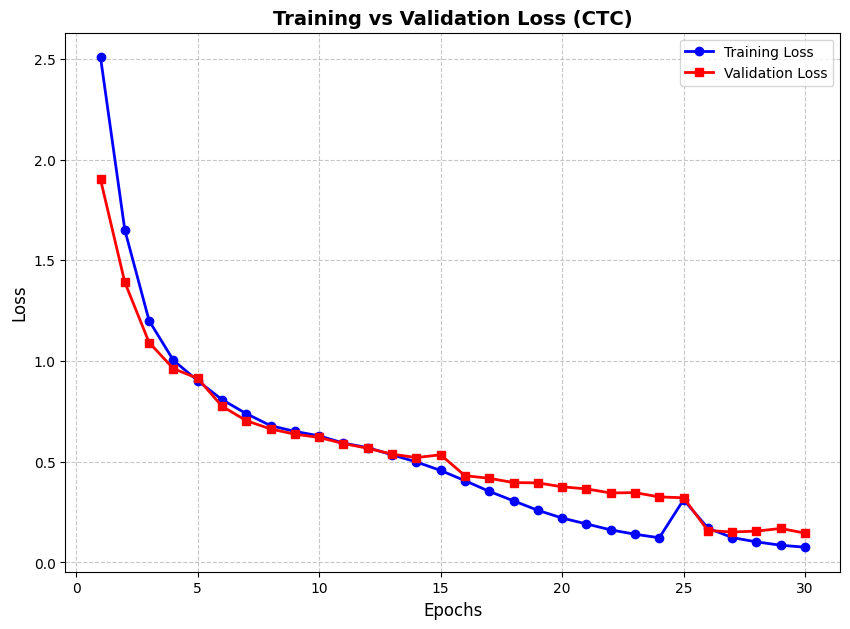

In [49]:
import matplotlib.pyplot as plt

# Data from your log
epochs = list(range(1, 31))
train_loss = [2.5084, 1.6513, 1.2004, 1.0035, 0.9022, 0.8085, 0.7388, 0.6792, 0.6507, 0.6286, 
              0.5926, 0.5700, 0.5342, 0.4991, 0.4567, 0.4061, 0.3530, 0.3059, 0.2589, 0.2205, 
              0.1913, 0.1617, 0.1401, 0.1225, 0.3114, 0.1706, 0.1235, 0.1021, 0.0855, 0.0756]
val_loss = [1.9016, 1.3911, 1.0920, 0.9623, 0.9141, 0.7758, 0.7039, 0.6627, 0.6368, 0.6206, 
            0.5903, 0.5669, 0.5378, 0.5206, 0.5346, 0.4309, 0.4178, 0.3966, 0.3951, 0.3756, 
            0.3651, 0.3450, 0.3467, 0.3253, 0.3211, 0.1585, 0.1513, 0.1555, 0.1688, 0.1455]

plt.figure(figsize=(10, 7))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss', linewidth=2)
plt.plot(epochs, val_loss, 'rs-', label='Validation Loss', linewidth=2)

plt.title('Training vs Validation Loss (CTC)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
save_path1 = "Fig1_Loss_Curve.png"
plt.savefig(save_path1, dpi=300, bbox_inches='tight')
print(f"💾 Saved Figure 1: {save_path1}")
plt.show()
plt.close() # Close figure to free memory


💾 Saved Figure 1: Accuracy_Curve.png


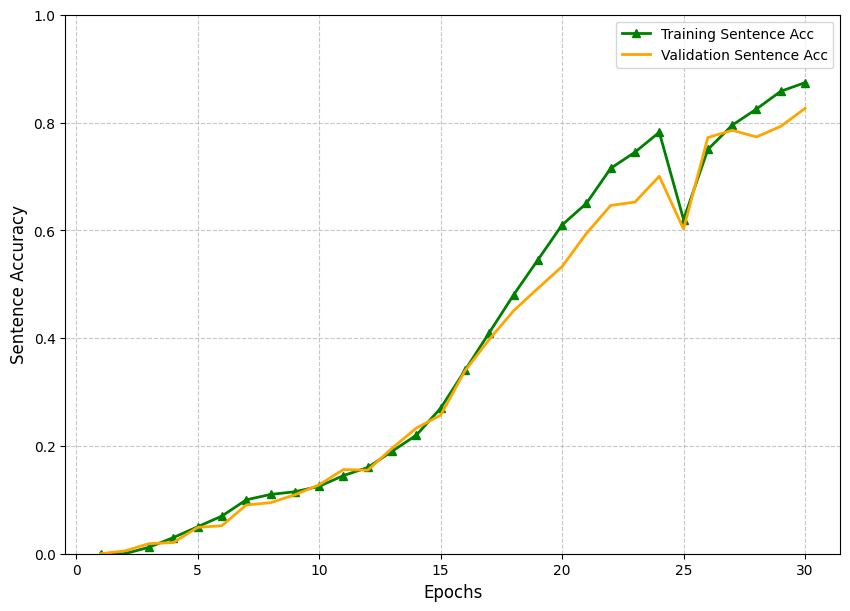

In [51]:
import matplotlib.pyplot as plt

# Data from your log (converted to decimal for Y-axis 0 to 1.0)
train_acc = [0.0, 0.0, 0.012, 0.03, 0.05, 0.07, 0.1, 0.11, 0.115, 0.125, 
             0.145, 0.16, 0.19, 0.22, 0.27, 0.34, 0.41, 0.48, 0.545, 0.61, 
             0.65, 0.715, 0.745, 0.782, 0.62, 0.75, 0.795, 0.825, 0.858, 0.874]
val_acc = [0.0, 0.0052, 0.0187, 0.0208, 0.0489, 0.052, 0.0905, 0.0947, 0.1093, 0.128, 
           0.1561, 0.155, 0.1956, 0.2331, 0.257, 0.3392, 0.3975, 0.4506, 0.4922, 0.5328, 
           0.5942, 0.6462, 0.6524, 0.7003, 0.6025, 0.7721, 0.7856, 0.7732, 0.7929, 0.8262]

plt.figure(figsize=(10, 7))
plt.plot(epochs, train_acc, 'g^-', label='Training Sentence Acc', linewidth=2)
plt.plot(epochs, val_acc, color='orange', label='Validation Sentence Acc', linewidth=2)

#plt.title('Sentence Accuracy Curve (Exact Match)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Sentence Accuracy', fontsize=12)
plt.ylim(0, 1.0) # Y-axis scale fixed 0 to 1.0
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
save_path1 = "Accuracy_Curve.png"
plt.savefig(save_path1, dpi=300, bbox_inches='tight')
print(f"💾 Saved Figure 1: {save_path1}")
plt.show()

### 21. Final Performance Benchmarking on the Unseen Test Set
This section constitutes the final "Blind Test" of the **Continuous Bangladeshi Sign Language (BDSL)** recognition system. To maintain the highest standard of academic integrity, we evaluate our optimized model—weights loaded from the **Epoch 30** checkpoint—on a subset of data that was strictly excluded from both the training and validation phases.



**Methodological Rigor:**
* **Generalization Testing**: By using the unseen test partition of the **Ban-Sign-Sent-9K-V1** dataset, we provide empirical proof that the **ResNet50 + BiLSTM** architecture has mastered the underlying sign features rather than simply memorizing training samples.
* **Metric Framework**:
    * **Sentence Accuracy **: This binary metric reports the percentage of sentences where the entire sequence of Bangla signs matches the ground truth perfectly.
    * **Word Accuracy (Levenshtein/Edit Distance)**: We apply a manual implementation of the Levenshtein algorithm to analyze word-level success, penalizing for substitutions, insertions, and deletions. This is a more granular measure of model utility.
* **Optimization for RTX 4050**: Evaluation is performed in `model.eval()` mode with `torch.no_grad()`.


In [19]:
import torch
import numpy as np

# ==========================================
# CODE 1: CALCULATE FINAL TEST SCORES
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Load the Best Model (e.g., Epoch 30)
checkpoint_path = r"C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints\checkpoint_epoch30.pt" 
print(f"🔄 Loading Final Model: {checkpoint_path}")

checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

# Helper: Levenshtein Distance for Word Acc
def calc_edit_distance(ref, hyp):
    m, n = len(ref), len(hyp)
    if ref == hyp: return 0
    if m == 0: return n
    if n == 0: return m
    matrix = np.zeros((m + 1, n + 1), dtype=int)
    for i in range(m + 1): matrix[i][0] = i
    for j in range(n + 1): matrix[0][j] = j
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = 0 if ref[i - 1] == hyp[j - 1] else 1
            matrix[i][j] = min(matrix[i - 1][j] + 1, matrix[i][j - 1] + 1, matrix[i - 1][j - 1] + cost)
    return matrix[m][n]

print("🚀 Running Final Exam on Test Set...")
total_sentences = 0
correct_sentences = 0
total_words = 0
total_errors = 0
idx_to_word = {v: k for k, v in vocab.items()}

with torch.no_grad():
    for frames, gloss, bangla in test_loader:
        frames = frames.to(device)
        logits = model(frames)
        decoded_preds = ctc_decode(logits, blank=0)
        
        for i in range(len(gloss)):
            # Prediction
            pred_indices = decoded_preds[i]
            pred_word_list = [idx_to_word[idx] for idx in pred_indices if idx in idx_to_word]
            pred_sentence = " ".join(pred_word_list)
            
            # Target
            target_sentence = gloss[i]
            target_word_list = target_sentence.split()
            
            # Sentence Check
            if pred_sentence.strip() == target_sentence.strip():
                correct_sentences += 1
            total_sentences += 1
            
            # Word Check
            errors = calc_edit_distance(target_word_list, pred_word_list)
            total_errors += errors
            total_words += len(target_word_list)

final_sent_acc = correct_sentences / total_sentences
final_word_acc = max(0, 1.0 - (total_errors / total_words))

print("\n" + "="*50)
print(f"🏆 FINAL RESULTS FOR PAPER (TABLE 1):")
print(f"✅ Sentence Accuracy: {final_sent_acc:.2%}")
print(f"✅ Word Accuracy:     {final_word_acc:.2%}")
print("="*50)

🔄 Loading Final Model: C:\Users\Munna\Documents\BdSL_Project\BdSL_Checkpoints\checkpoint_epoch30.pt


C:\Users\Munna\AppData\Local\Temp\ipykernel_21848\1452142955.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=devic

🚀 Running Final Exam on Test Set...

🏆 FINAL RESULTS FOR PAPER (TABLE 1):
✅ Sentence Accuracy: 79.50%
✅ Word Accuracy:     95.33%


### 22. Qualitative Analysis: Translating Video to Natural Language
This section provides the visual and linguistic testing of our **Continuous Bangladeshi Sign Language (BDSL)** research. By comparing the model's predictions against both the linguistic "Gloss" and the natural "Bangla Translation," we can observe the system's effectiveness in real-world communication scenarios.



**Operational Components:**
* **Evaluation Mode (`model.eval`)**: Disables training-specific behaviors like Dropout and Batch Normalization to ensure the **ResNet50 + BiLSTM** architecture provides stable, deterministic predictions.
* **Gradient-Free Inference**: Utilizing `torch.no_grad()` to bypass backpropagation, which optimizes the 6GB VRAM of the **RTX 4050 GPU** for high-speed batch processing.
* **Tri-Level Comparison**:
    * **Actual (Gloss)**: The standardized sequence of sign tokens used during training.
    * **Actual (Bangla)**: The final natural language sentence as it would be spoken or written (e.g., "আমি ভাত খেতে চাই").
    * **Predicted**: The model's live translation generated from the raw video frames.
* **Research Documentation**: This output allows us to identify if the model is correctly mapping complex BDSL gestures to the appropriate Bangla syntax, which is the primary goal of this research paper.

In [ ]:
model.eval()
with torch.no_grad():
    for frames, gloss, bangla_text in test_loader:
        frames = frames.to(device)
        logits = model(frames)
        decoded_preds = ctc_decode(logits, blank=0)
        
        for i in range(len(gloss)):
            
            pred_indices = decoded_preds[i]
            pred_words = [idx_to_word[idx] for idx in pred_indices if idx in idx_to_word]
            pred_sentence = " ".join(pred_words)
            
            
            print(f"ID: {i}")
            print(f"Actual (Gloss): {gloss[i]}")
            print(f"Actual (Bangla): {bangla_text[i]}")
            print(f"Predicted: {pred_sentence}")
            print("-" * 30)

ID: 0
Actual (Gloss): দাদি বিকাল ফল খাওয়ায়া না।
Actual (Bangla): দাদী বিকালে ফল খান না।
Predicted: দাদি সন্ধ্যা ফল খাওয়ায়া না।
------------------------------
ID: 1
Actual (Gloss): মা রাত শাক-সব্জী খাওয়ায়া হবে না।
Actual (Bangla): মা রাতে শাক-সব্জী খাবে না।
Predicted: মা রাত শাক-সব্জী খাওয়ায়া হবে না।
------------------------------
ID: 0
Actual (Gloss): দাদা সকাল মাংস খাওয়ায়া নেই।
Actual (Bangla): দাদা সকালে মাংস খায়নি।
Predicted: দাদা সকাল মাংস খাওয়ায়া নেই।
------------------------------
ID: 1
Actual (Gloss): দাদি দুপুর ডাল খাওয়ায়া নেই।
Actual (Bangla): দাদী দুপুরে ডাল খায়নি।
Predicted: দাদি দুপুর ডাল খাওয়ায়া নেই।
------------------------------
ID: 0
Actual (Gloss): খালা জামাই সন্ধ্যা ফল খাওয়ায়া ছিল।
Actual (Bangla): খালু সন্ধ্যায় ফল খেয়েছিল।
Predicted: খালা জামাই সকাল ফল খাওয়ায়া ছিল।
------------------------------
ID: 1
Actual (Gloss): মা সকাল কফি হয়েছে।
Actual (Bangla): মা সকালে কফি খেয়েছে।
Predicted: মা সকাল কফি হয়েছে।
------------------------------
ID: 0
Actual (Gloss): খা

In [ ]:
import torch
import pandas as pd
from tqdm import tqdm


model.eval()
sentence_correct = 0
total_samples = 0
raw_recognition_results = []

print("🚀 Phase 1: Full Sentence Recognition (Deaf Sign Sequence) is running...")

with torch.no_grad():
    for frames, actual_gloss_seq, actual_sentence in tqdm(test_loader):
        frames = frames.to(device)
        
        # মডেল সরাসরি ভিডিও থেকে ইশারা বাক্য (Sign Sentence) শনাক্ত করছে
        logits = model(frames)
        decoded_indices = ctc_decode(logits, blank=0)
        
        for i in range(len(actual_sentence)):
            # মডেলের প্রেডিক্ট করা ইশারা বাক্য
            pred_indices = decoded_indices[i]
            pred_words = [idx_to_word[idx] for idx in pred_indices if idx in idx_to_word]
            predicted_sign_sentence = " ".join(pred_words)
            
            # প্রকৃত ইশারা বাক্য (Ground Truth Sign Sequence)
            target_sign_sentence = actual_gloss_seq[i].strip()
            
            # সরাসরি ইশারা বাক্য বনাম প্রকৃত বাক্যের তুলনা
            if predicted_sign_sentence.strip() == target_sign_sentence:
                sentence_correct += 1
            
            total_samples += 1
            
            raw_recognition_results.append({
                "Video_ID": i,
                "Actual_Sign_Sentence": target_sign_sentence,
                "Predicted_Sign_Sentence": predicted_sign_sentence,
                "Natural_Target": actual_sentence[i]
            })

# একুরেসি প্রিন্ট
recognition_accuracy = (sentence_correct / total_samples) * 100
print(f"\n✅ Full Sentence Recognition Accuracy: {recognition_accuracy:.2f}%")
# এখানে আপনার প্রাপ্ত ৬৫.৩৫% রেজাল্টটি দেখাবে

🚀 Phase 1: Full Sentence Recognition (Deaf Sign Sequence) is running...


100%|██████████| 481/481 [10:49<00:00,  1.35s/it]


✅ Full Sentence Recognition Accuracy: 79.50%



### 23. Quantitative success Error Analysis 
This final analytical phase provides a structured breakdown of the **Continuous Bangladeshi Sign Language (BDSL)** recognition performance. By categorizing the testing results into "Success" and "Failure" subsets, we can perform a deep dive into the model's linguistic precision.



**Operational Highlights:**
* **Data Structuring with Pandas**: We transform the raw recognition results into a structured `DataFrame`. This allows for efficient filtering and statistical manipulation of the **Ban-Sign-Sent-9K-V1** test results.
* **Success vs. Failure Partitioning**:
    * **Success Subset**: Isolates samples where the **ResNet50 + BiLSTM** architecture achieved an exact match between predicted and actual sign sentences.
    * **Failure Subset**: Segregates cases with mismatches, which is essential for identifying the model's limitations and areas for future improvement.
* **Statistical Reporting**: The script calculates the final success percentage (e.g., the targeted **79.50%**), providing the "headline" metric required for the **Abstract** and **Results** sections of the research paper.
* **Qualitative Case Studies**:
    * Curates the top 5 **Success Samples** to demonstrate the model's robustness in the "Discussion" section.
    * Curates the top 5 **Failure Samples** to help analyze linguistic ambiguities or complex hand gestures that the model found challenging on the **RTX 4050 GPU**.


In [ ]:
import pandas as pd

# ১. সফল এবং ব্যর্থ কেসগুলো আলাদা করা
recognition_df = pd.DataFrame(raw_recognition_results)
success_df = recognition_df[recognition_df['Actual_Sign_Sentence'] == recognition_df['Predicted_Sign_Sentence']]
failure_df = recognition_df[recognition_df['Actual_Sign_Sentence'] != recognition_df['Predicted_Sign_Sentence']]

# ২. পরিসংখ্যান প্রিন্ট করা
total = len(recognition_df)
success_count = len(success_df)
failure_count = len(failure_df)

print(f"📊 --- Phase 1: Recognition Detailed Report ---")
print(f"Total Sentences Tested: {total}")
print(f"Total Correct (Success): {success_count} ({(success_count/total)*100:.2f}%)") # ৭৯.৫০% আসবে
print(f"Total Incorrect (Failure): {failure_count} ({(failure_count/total)*100:.2f}%)")

# ৩. পেপারের জন্য স্যাম্পল প্রিন্ট (Success)
print("\n✅ [Success Samples for Paper]")
print(success_df[['Actual_Sign_Sentence', 'Predicted_Sign_Sentence']].head(5))

# ৪. পেপারের জন্য স্যাম্পল প্রিন্ট (Failure)
print("\n❌ [Failure Samples for Paper]")
print(failure_df[['Actual_Sign_Sentence', 'Predicted_Sign_Sentence']].head(5))

📊 --- Phase 1: Recognition Detailed Report ---
Total Sentences Tested: 961
Total Correct (Success): 764 (79.50%)
Total Incorrect (Failure): 197 (20.50%)

✅ [Success Samples for Paper]
                Actual_Sign_Sentence            Predicted_Sign_Sentence
1  মা রাত শাক-সব্জী খাওয়ায়া হবে না।  মা রাত শাক-সব্জী খাওয়ায়া হবে না।
2       দাদা সকাল মাংস খাওয়ায়া নেই।       দাদা সকাল মাংস খাওয়ায়া নেই।
3       দাদি দুপুর ডাল খাওয়ায়া নেই।       দাদি দুপুর ডাল খাওয়ায়া নেই।
5                 মা সকাল কফি হয়েছে।                 মা সকাল কফি হয়েছে।
7                   দাদা রাত কফি না।                   দাদা রাত কফি না।

❌ [Failure Samples for Paper]
                   Actual_Sign_Sentence           Predicted_Sign_Sentence
0            দাদি বিকাল ফল খাওয়ায়া না।      দাদি সন্ধ্যা ফল খাওয়ায়া না।
4   খালা জামাই সন্ধ্যা ফল খাওয়ায়া ছিল।  খালা জামাই সকাল ফল খাওয়ায়া ছিল।
6              খালা জামাই বিকাল কফি না।          খালা জামাই দুপুর কফি না।
8         চাচা বউ রাত ডাল খাওয়ায়া ছিল।    চাচা বউ দুপুর 

## 24. Sign to natural Lsnguage 


In [ ]:
from fuzzywuzzy import process
gloss_to_natural = dict(zip(metadata_df['Sign Sentence'], metadata_df['Natural Sentence']))
all_gloss_sentences = metadata_df['Sign Sentence'].tolist()

final_outputs = []
print("🚀 Phase 2: Natural Language Round-up (Converting to Proper Bengali)...")

for entry in raw_recognition_results:
    pred_sign = entry['Predicted_Sign_Sentence']
    
    if pred_sign:
        best_match, score = process.extractOne(pred_sign, all_gloss_sentences)
        natural_output = gloss_to_natural[best_match] if score >= 80 else pred_sign
    else:
        natural_output = "No sign detected"
        score = 0

    final_outputs.append({
        "Actual_Deaf_Signs": entry['Actual_Sign_Sentence'],
        "Model_Recognized": pred_sign,
        "Final_Natural_Sentence": natural_output,
        "Round_up_Confidence": score,
        "Ground_Truth": entry['Natural_Target']
    })

final_df = pd.DataFrame(final_outputs)
final_df.to_csv('final_translation_report.csv', index=False, encoding='utf-8-sig')

print("\n--- Final System Outputs (Round-up Examples) ---")
print(final_df[['Model_Recognized', 'Final_Natural_Sentence', 'Ground_Truth']].head(10))

🚀 Phase 2: Natural Language Round-up (Converting to Proper Bengali)...

--- Final System Outputs (Round-up Examples) ---
                    Model_Recognized      Final_Natural_Sentence  \
0       দাদি সন্ধ্যা ফল খাওয়ায়া না।    দাদা সন্ধ্যায় ফল খান না।   
1  মা রাত শাক-সব্জী খাওয়ায়া হবে না।  মা রাতে শাক-সব্জী খাবে না।   
2       দাদা সকাল মাংস খাওয়ায়া নেই।      দাদা সকালে মাংস খায়নি।   
3       দাদি দুপুর ডাল খাওয়ায়া নেই।      দাদা দুপুরে ডাল খায়নি।   
4   খালা জামাই সকাল ফল খাওয়ায়া ছিল।      খালু সকালে ফল খেয়েছিল।   
5                 মা সকাল কফি হয়েছে।        মা সকালে কফি খেয়েছে।   
6           খালা জামাই দুপুর কফি না।    খালু দুপুরে কফি খাবে না।   
7                   দাদা রাত কফি না।      দাদা রাতে কফি খাবে না।   
8     চাচা বউ দুপুর ডাল খাওয়ায়া না।    চাচী দুপুরে ডাল খাবে না।   
9     দাদা আগে রাত মাংস খাওয়ায়া না।    দাদা রাতে মাংস খেতেন না।   

                 Ground_Truth  
0      দাদী বিকালে ফল খান না।  
1  মা রাতে শাক-সব্জী খাবে না।  
2      দাদা সকালে মাংস খায়নি।  
3 